# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**
- Данные геологоразведки трёх регионов находятся в файлах:  
https://code.s3.yandex.net/datasets/geo_data_0.csv  
https://code.s3.yandex.net/datasets/geo_data_1.csv  
https://code.s3.yandex.net/datasets/geo_data_2.csv  


- id — уникальный идентификатор скважины;  
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
- product — объём запасов в скважине (тыс. баррелей).  

**Условия задачи:**  
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
- Бюджет на разработку скважин в регионе — 10 млрд рублей.  
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

In [2]:
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
df2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
df3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Изучим первый датасет.

In [3]:
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
df1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Создадим функцию для построения гистограмм и ящиков с усами по численным данным. 

In [6]:
def hist_box_numeric(df):
    fig = plt.figure()
    figsize=(15,20)
    total_axes = len(df.describe().columns)*2 

    subplt = 1 
    for column in df.describe().columns:
        if int(df[column].max()-df[column].min()+1)>100:
            bins=100
        elif int(df[column].max()-df[column].min()+1)<=20:
            bins=100     
        else:
            bins = int(df[column].max()-df[column].min()+1)
        ax = fig.add_subplot(total_axes, 1, subplt)
        df.boxplot([column], vert=False)
        subplt+=1
        ax = fig.add_subplot(total_axes, 1, subplt)
        df[column].plot(kind='hist', bins=bins, figsize=(12,20), grid=True, legend=True)
        subplt+=1
    
    plt.tight_layout()
    plt.show()

Создадим функцию для представления корреляционной матрицы с помощью тепловой карты.

In [7]:
def corr_heatmap(df):
    df_corr = df.corr().replace(1,0)

    mask = np.zeros_like(df_corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize=(18, 7))

    sns.heatmap(df_corr, mask=mask, annot=True, fmt=".5f", linewidths=.1, cmap= 'coolwarm')
    plt.title('Матрица коэффициентов линейной корреляции', fontsize=15)
    plt.ylabel('Признак', fontsize=15)
    plt.xlabel('Признак', fontsize=15)

Строим гистограммы и ящики с усами для первого датасета.

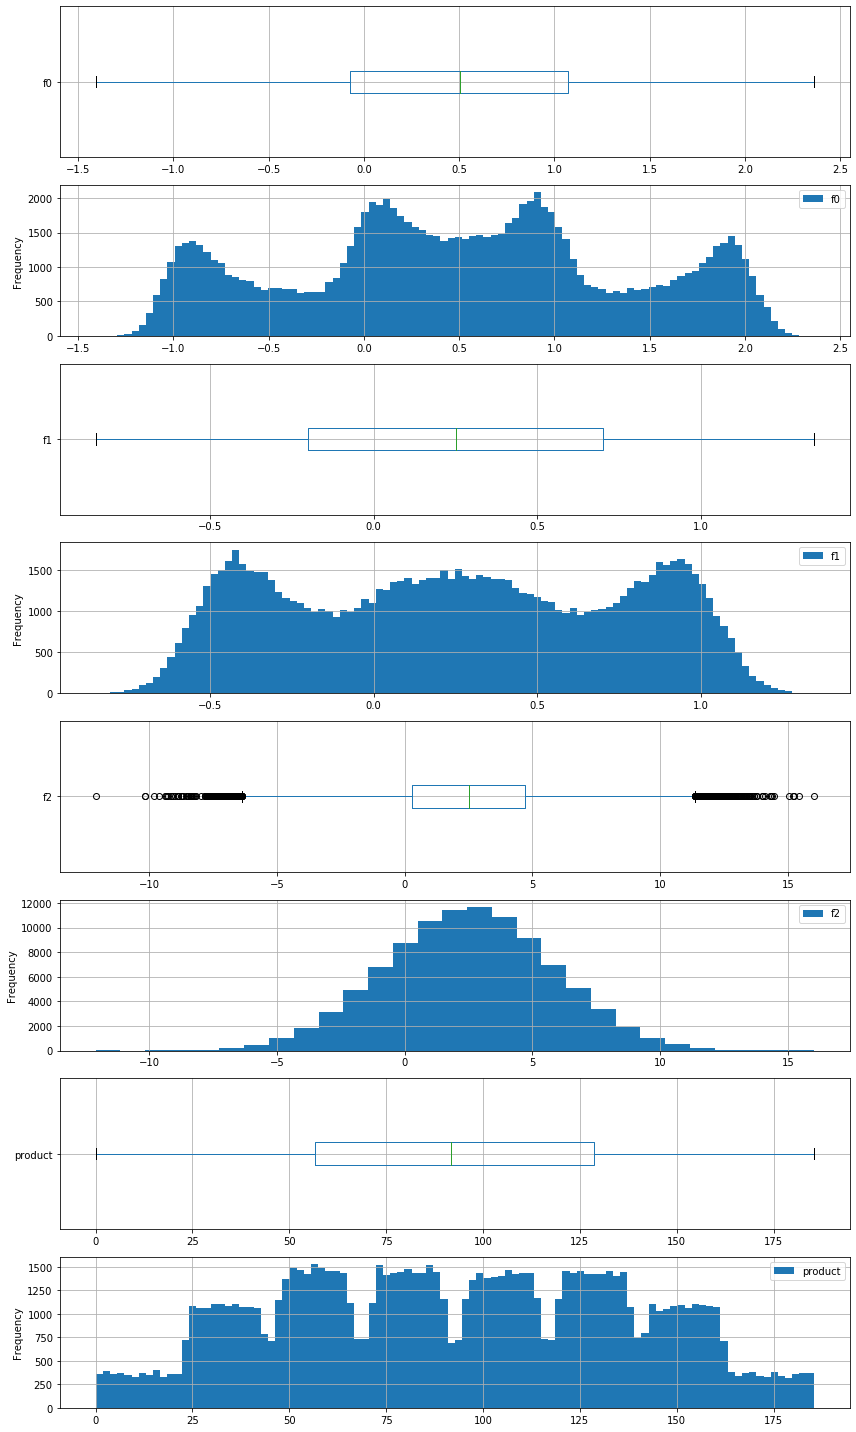

In [8]:
hist_box_numeric(df1)

Строим корреляционную матрицу для первого датасета. 

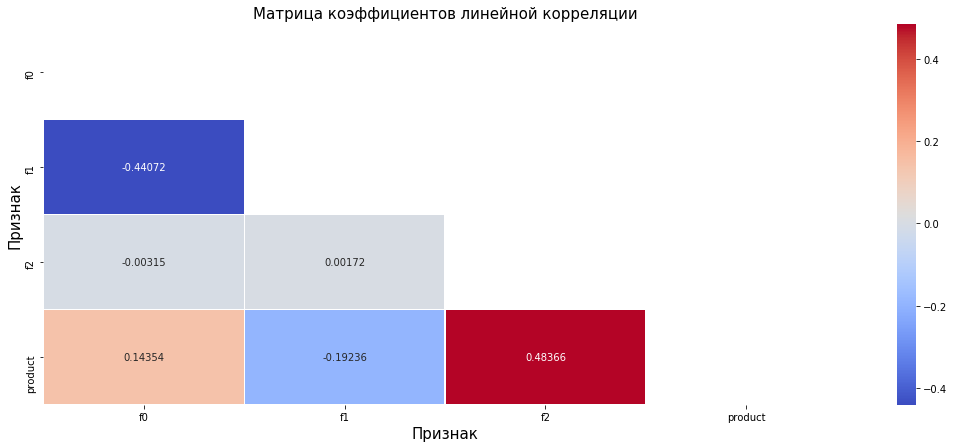

In [9]:
corr_heatmap(df1)

В первом датасете:
- пропуски отсутствуют;
- у признака f0 тип распределения гребенка с 4-мя пиками в районе значений -1, 0, 1, 2;
- у признака f1 тип распределения гребенка с 3-мя пиками в районе значений -0,375, 0,25, 0,875;
- у признака f2 наблюдается нормальное распределение около значения 2,5;
- целевой признак так же имеет тип гребенки, но с 6-ю пиками в районе значений 31, 56, 80, 105, 127, 150.
- наблюдается слабая отрицательная корреляция между признаками f0 и f1 k=-0.44;
- имеется слабая положительная корреляция между признаком f2 и целевым признаком product k=0.48;
- отрицательных или аномально высоких значений в целевом признаке нет, в признаках так же остутствуют аномальные значения.

### Изучим второй датасет.

In [10]:
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
df2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


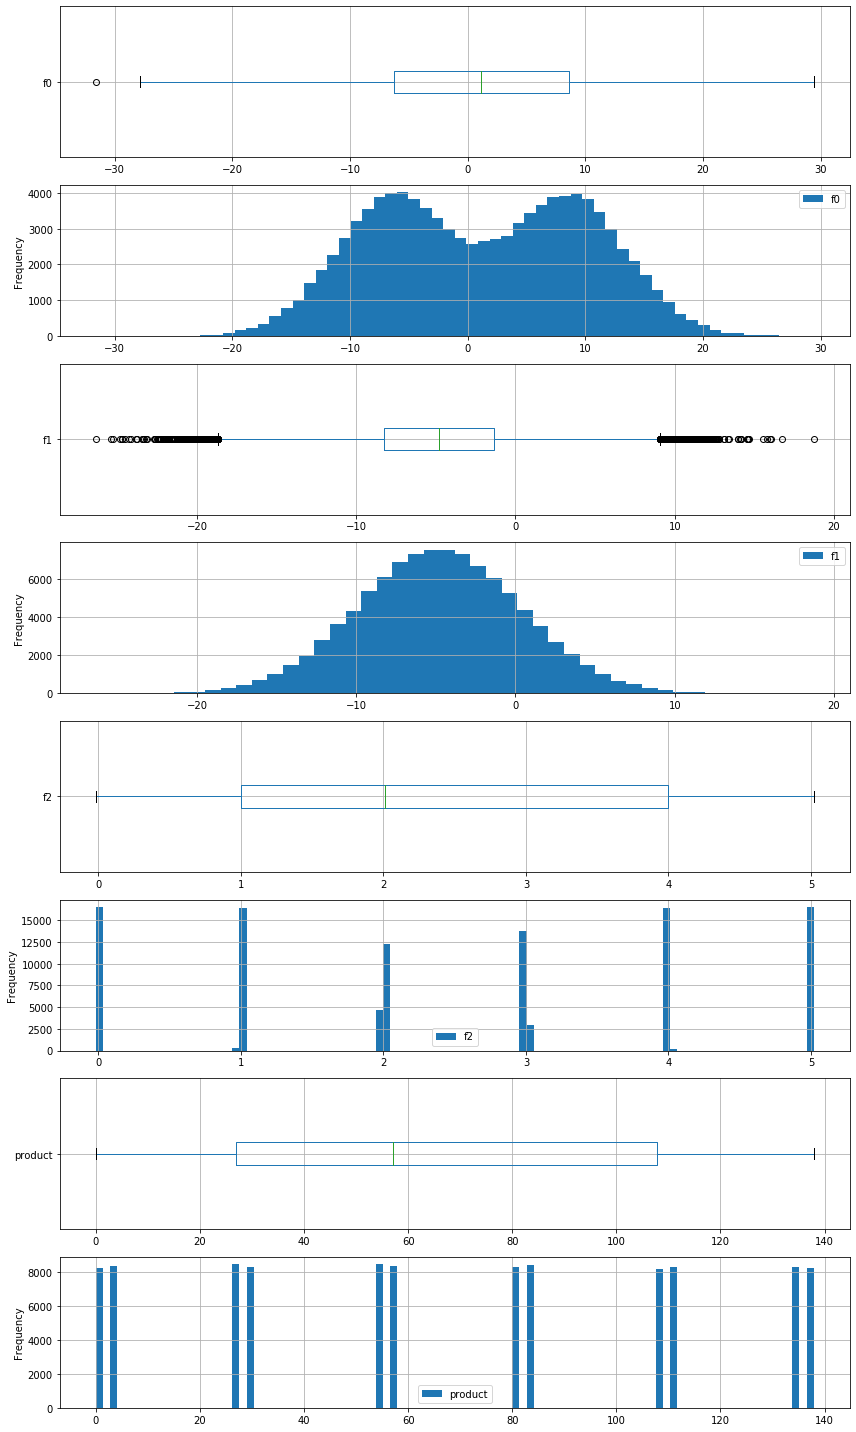

In [13]:
hist_box_numeric(df2)

Проверим интервалы между значениям целевого признака. Имеется 6 групп значений, в каждой группе по два значения. Группируем датасет по целевому найдем разность:
- между группами значений (например 0 и ~25 для первой и второй группы);
- между парами значений в группе (например 0 и ~5 для первой группы).

In [14]:
prod_values_df2 = df2.groupby('product').count().reset_index()
prod_values_df2

,product,id,f0,f1,f2
0,0.000000,8235,8235,8235,8235
1,3.179103,8337,8337,8337,8337
2,26.953261,8468,8468,8468,8468
3,30.132364,8306,8306,8306,8306
4,53.906522,8472,8472,8472,8472
5,57.085625,8390,8390,8390,8390
6,80.859783,8320,8320,8320,8320
7,84.038886,8431,8431,8431,8431
8,107.813044,8201,8201,8201,8201
9,110.992147,8303,8303,8303,8303


In [15]:
for i in range(1, len(prod_values_df2)-1, 2):
    difference = prod_values_df2.loc[(i+1), 'product'] - prod_values_df2.loc[i, 'product']
    print("Значение разности: {:.8f} | Индексы датасета: {} - {} | Разность чисел: {:.4f} - {:.4f}".format(difference, i+1, i, prod_values_df2.loc[i+1, 'product'], prod_values_df2.loc[(i), 'product']))

Значение разности: 23.77415845 | Индексы датасета: 2 - 1 | Разность чисел: 26.9533 - 3.1791
Значение разности: 23.77415845 | Индексы датасета: 4 - 3 | Разность чисел: 53.9065 - 30.1324
Значение разности: 23.77415845 | Индексы датасета: 6 - 5 | Разность чисел: 80.8598 - 57.0856
Значение разности: 23.77415845 | Индексы датасета: 8 - 7 | Разность чисел: 107.8130 - 84.0389
Значение разности: 23.77415845 | Индексы датасета: 10 - 9 | Разность чисел: 134.7663 - 110.9921


Значения разности одни и те же.

In [16]:
for i in range(0, len(prod_values_df2), 2):
    difference = prod_values_df2.loc[(i+1), 'product'] - prod_values_df2.loc[i, 'product']
    print("Значение разности: {:.8f} | Индексы датасета: {} - {} | Разность чисел: {:.4f} - {:.4f}|".format(difference, i+1, i, prod_values_df2.loc[i+1, 'product'], prod_values_df2.loc[(i), 'product']))

Значение разности: 3.17910258 | Индексы датасета: 1 - 0 | Разность чисел: 3.1791 - 0.0000|
Значение разности: 3.17910258 | Индексы датасета: 3 - 2 | Разность чисел: 30.1324 - 26.9533|
Значение разности: 3.17910258 | Индексы датасета: 5 - 4 | Разность чисел: 57.0856 - 53.9065|
Значение разности: 3.17910258 | Индексы датасета: 7 - 6 | Разность чисел: 84.0389 - 80.8598|
Значение разности: 3.17910258 | Индексы датасета: 9 - 8 | Разность чисел: 110.9921 - 107.8130|
Значение разности: 3.17910258 | Индексы датасета: 11 - 10 | Разность чисел: 137.9454 - 134.7663|


Значения разности снова одни и те же.

Строим матрицу корреляции.

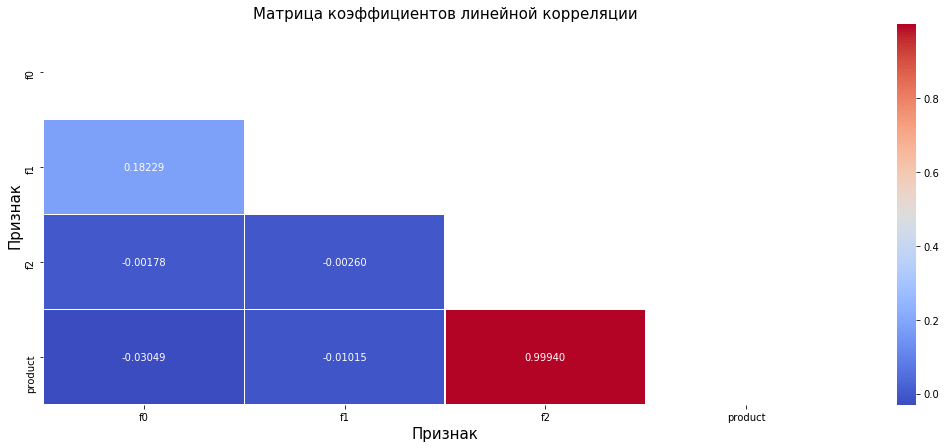

In [17]:
corr_heatmap(df2)

Во втором датасете:
- пропуски отсутствуют;
- у признака f0 тип распределения бимодальное с пиками в районе значений -7, 8;
- у признака f1 нормальное распределение около значения -5;
- **у признака f2 гистограмма имеет вид столбчатой диаграммы со значениями 0, 1, 2, 3, 4, 5;**
- **целевой признак так же имеет вид столбчатой диаграммы, но с парой пиков в каждом значении около 0, 30, 55, 80, 110, 135.**
- наблюдается очень слабая положительная корреляция между признаками f0 и f1 k=0.18;
- **имеется очень высокая положительная корреляция между признаком f2 и целевым признаком product k=0.9994.**

- **для каждой группы и подгруппы целевого признака наблюдается совпадание значения разности до 8-го знака после запятой. Можно предположить, что исходный датасет был заранее предобработан и сгруппирован.**

### Изучим третий датасет.

In [18]:
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [19]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [20]:
df3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


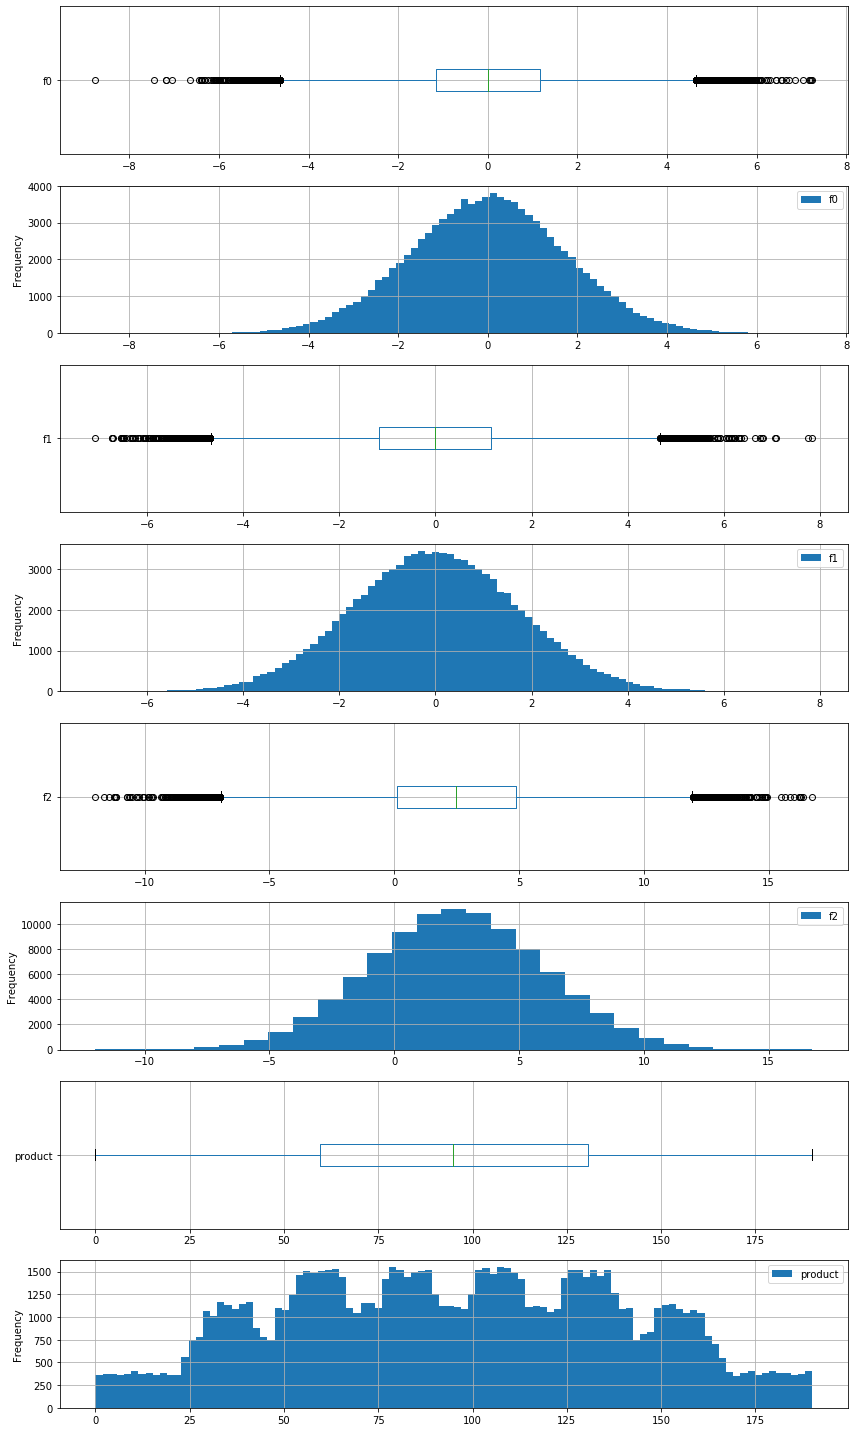

In [21]:
hist_box_numeric(df3)

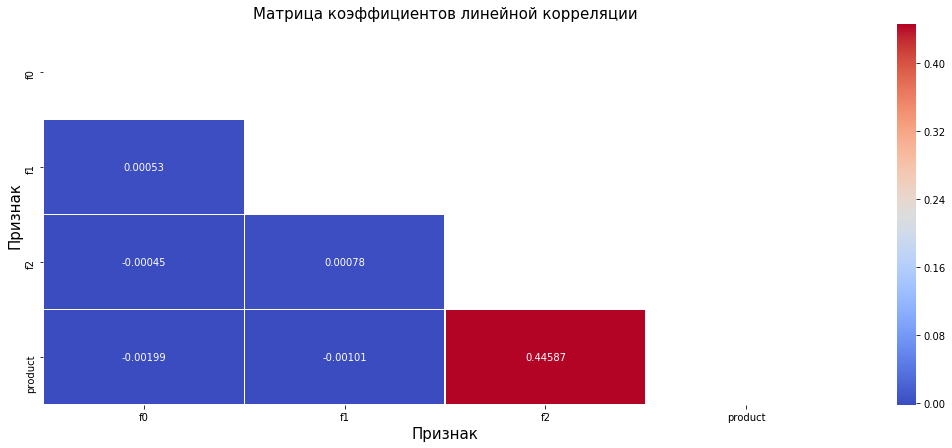

In [22]:
corr_heatmap(df3)

В третьем датасете:
- пропуски отсутствуют;
- у признака f0 нормальное распределение около значения 0;
- у признака f1 нормальное распределение около значения 0;
- у признака f1 нормальное распределение около значения 2,5;
- целевой признак имеет тип гребенки, с 6-ю пиками в районе значений 31, 56, 80, 105, 127, 150.
- имеется слабая положительная корреляция между признаком f2 и целевым признаком product k=0.446;
- отрицательных или аномально высоких значений в целевом признаке нет, в признаках так же остутствуют аномальные значения.

### Провека на дубликаты.

Проверим дубликаты во всех датасетах.

In [23]:
count = 1
for df in df1, df2, df3:    
    print(f'Полных дубликатов в df{count}: {df.duplicated().sum()}')
    for column in df.columns:
        print(f'Повторяющихся значений в колонке "{column}": {df[column].duplicated().sum()}')
    print()
    count += 1

Полных дубликатов в df1: 0
Повторяющихся значений в колонке "id": 10
Повторяющихся значений в колонке "f0": 0
Повторяющихся значений в колонке "f1": 0
Повторяющихся значений в колонке "f2": 0
Повторяющихся значений в колонке "product": 0

Полных дубликатов в df2: 0
Повторяющихся значений в колонке "id": 4
Повторяющихся значений в колонке "f0": 0
Повторяющихся значений в колонке "f1": 0
Повторяющихся значений в колонке "f2": 0
Повторяющихся значений в колонке "product": 99988

Полных дубликатов в df3: 0
Повторяющихся значений в колонке "id": 4
Повторяющихся значений в колонке "f0": 0
Повторяющихся значений в колонке "f1": 0
Повторяющихся значений в колонке "f2": 0
Повторяющихся значений в колонке "product": 0



Значения целевого признака второго датасета трогать не будем, так при удалении дубликатов останется всего 12 объектов и по ним модель не построить. 

Удалим объекты с дублирующимися id, так как исходя из описания данных id должен быть уникальным.

In [24]:
df1 = df1.drop_duplicates(subset=['id'])
df2 = df2.drop_duplicates(subset=['id'])
df3 = df3.drop_duplicates(subset=['id'])

Проверим количество строк после удаления дублирующихся id.

In [25]:
for df in  df1, df2, df3:
    print(df.shape[0])

99990
99996
99996


От 4 до 10 строк были удалены из-за дублирующихся id. Это менее 0,01% строк в датасетах.

### Выделение признаков и целевого признака.

Добавим датафрейм признаков "xx" и целевого признака "yy" для каждого датасета (региона) в соответствующие списки датафремов.  
Колонку "id" не включаем в признаки, так как она не несет полезной информации для обучения моделей.  
Для получения датасета по каждому региону в дальнейшем будем обращаться к этим спискам по строке:
- 0 - датасет №1, 
- 1 - датасет №2, 
- 2 - датасет №3.

In [26]:
xx = []
yy = []

for df in  df1, df2, df3:
    xx.append(df.drop(columns=['product', 'id'], axis=1))
    yy.append(df[['product']])

Проверим размерность датафреймов с признаками и целевыми признаками для каждого региона.

In [27]:
for region in range(len(xx)):
    print("Признаки региона", region + 1, xx[region].shape)
    print("Целевые признаки региона", region + 1, yy[region].shape)
    print()

Признаки региона 1 (99990, 3)
Целевые признаки региона 1 (99990, 1)

Признаки региона 2 (99996, 3)
Целевые признаки региона 2 (99996, 1)

Признаки региона 3 (99996, 3)
Целевые признаки региона 3 (99996, 1)



### Вывод

Проведена предобработка данных в ходе которой исследованы три датасета, для трех регионов. Наибольшее внимание вызывает второй датасет, в котором целевые признаки системно сгруппированы, а так же имеется очень сильная положительная корреляция между признаком f2 и целевым признаком product k=0.99994. Исключать его из дальнейшей работы не будем, но отметим его странность.  
Так же в ходе проверки на дубликаты во всех датасетах обнаружены дублирующиеся id, которые были удалены. Всего это менее 0,01% данных.  
Для всех дататсетов в отдельные списки выделены датафреймы с признаками и целевыми признаками.

## Обучение и проверка модели

### Разделение данных на обучающую и валидационную выборки в соотношении 75:25.

Напишем функцию разделения данных на две выборки.

In [28]:
def split_train_valid(features, target, size=0.25):
    x_train, x_valid, y_train, y_valid = train_test_split(
    features, target, test_size=size, random_state=12345)
    return x_train, x_valid, y_train, y_valid

Применим функцию разделения датафрейма на обучающую и валидационную выборки для каждого региона. Полученные датафремы сохраним в списки:
- xx_train - обучающие признаки
- xx_valid - валидационные признаки
- yy_train - обучающие целевые признаки
- yy_valid - валидационные целевые признаки

In [29]:
xx_train=[]
xx_valid=[]
yy_train=[]
yy_valid=[]
for region in range(len(xx)):
    x_train, x_valid, y_train, y_valid = split_train_valid(xx[region], yy[region], 0.25)
    xx_train.append(x_train)
    xx_valid.append(x_valid)
    yy_train.append(y_train)
    yy_valid.append(y_valid)

Проверим соотношение обучающей и валидационной выборки трех регионов.

In [30]:
for region in range(len(xx)):
    print(f"{len(xx_train[region])/len(xx[region]):.0%}/{len(xx_valid[region])/len(xx[region]):.0%}")

75%/25%
75%/25%
75%/25%


**Проведем масштабирование признаков методом стандартизации.** 

Напишем функцию для масштабирования признаков. Обучаем Scaler на обучающих признаках и трансформируем обучающую и валидационную выборки.

In [31]:
def scaled_features(features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train[list(features_train.columns)])
    features_train[list(features_train.columns)] = scaler.transform(features_train[list(features_train.columns)])
    features_valid[list(features_valid.columns)] = scaler.transform(features_valid[list(features_valid.columns)])
    return features_train, features_valid 

Масштабируем обучающие и валидационные признаки для трех регионов. Результаты сохраняем в списки датафреймов xx_train_scaled и xx_valid_scaled.

In [32]:
xx_train_scaled=[]
xx_valid_scaled=[]
for region in range(len(xx)):
    x_train_scaled, x_valid_scaled = scaled_features(xx_train[region], xx_valid[region])
    xx_train_scaled.append(x_train_scaled)
    xx_valid_scaled.append(x_valid_scaled)

Выведем для наглядность один датафрейм со стандартизированными обучающими признаками для второго региона.

In [33]:
xx_train_scaled[1]

,f0,f1,f2
7866,1.969969,1.837435,0.297397
83622,-0.814630,1.729298,0.303413
45142,-1.137949,0.734327,1.476398
35823,0.656865,1.949531,-1.461694
17773,1.769386,-0.319261,0.885476
...,...,...,...
4094,-0.335067,-0.002238,0.298623
85416,0.724171,-1.142061,0.299137
2177,1.045694,-0.647861,1.475461
77286,-1.100147,-1.101652,0.300384


### Обучение модели и получение предсказаний на валидационной выборке.

Напишем функцию обучения модели линейной регрессии получающей на вход обучающие и валидационные признаки и целевые признаки, а возвращающую модели, предсказания, RMSE и среднее значение предсказанного целевого признака.

In [34]:
def lin_r_result(x_train, y_train, x_valid, y_valid):    
    model = LinearRegression()
    model.fit(x_train, y_train)
    predict = model.predict(x_valid)
    rmse = mean_squared_error(y_valid, predict)** 0.5
    mean = predict.mean()
    return model, predict, rmse, mean

Применим функцию для для трех регионов, обучать и проверять модель будет на масштабированных признаках. Сохраним результы в списках:
- model_yy - обученные модели
- predict_yy - предсказания целевого признака
- rmse_yy - квадратный корень из среднеквадратичной ошибки (RMSE)
- mean_yy - среднее значение предсказанного целевого признака в датасете

In [35]:
model_yy = []
predict_yy = []
rmse_yy = []
mean_yy = []
for i in range(len(xx)):
    model, predict, rmse, mean = lin_r_result(xx_train_scaled[i], yy_train[i], xx_valid_scaled[i], yy_valid[i])
    model_yy.append(model)
    predict_yy.append(predict)
    rmse_yy.append(rmse)
    mean_yy.append(mean)
    

Сведем данные по RMSE и среднему значению предсказанного целевого признака (объём запасов в скважине в тыс. баррелей) для каждого региона в один датафрейм для наглядности.

In [36]:
index= ['rmse', 'mean_predict']
columns = ['region_1','region_2','region_3']
result = pd.DataFrame(data = [rmse_yy, mean_yy], columns = columns, index = index).T
result

,rmse,mean_predict
region_1,37.853527,92.789156
region_2,0.892059,69.178320
region_3,40.075851,94.865725


Сохраним предсказания и правильные ответы на валидационной выборке для каждого региона в один список датафреймов - df_predict_product.


In [37]:
df_predict_product = []
for i in range(len(xx)):
    d=yy_valid[i].join(pd.DataFrame(data= predict_yy[i], columns = ['predict'], index=list(yy_valid[i].index)))
    df_predict_product.append(d)

Для наглядности выведем первые 5 строк получившегося датафрейма для первого региона.

In [38]:
df_predict_product[0].head(5)

,product,predict
49468,123.566299,103.950372
55496,63.442039,73.687869
11690,88.718000,101.015288
13770,51.422060,94.048415
72395,102.569999,87.559552


### Вывод

- данные разделены на обучающую и валидационную выборки в соотношении 75/25;
- признаки смасштабированны методом стандартизации;
- модели линейной регрессии обучены и получены предсказация и метрики. Значения RMSE и среднее предсказанное значение для каждого региона сведены в датафрейм result;  
- наименьший RMSE и среднее значение предсказанного целевого признака у второго региона, равные 0,89 и 69 соответственно. Для первого и второго региона значения RMSE и среднего предсказания находятся в диапазоне 38-40 и 93-95 соответственно;
- предсказания и правильные ответы для валидационной выборки каждого датасета сохранены с список df_predict_product.  

Второй регион снова выделяется на фоне остальных.

## Подготовка к расчёту прибыли

Сохраним все ключевые значения для расчётов в отдельных переменных.


In [39]:
budget = 10*10**9 #бюждет на разработку скважин в регионе в рублях 
bore_explore = 500 #количество исслудуемых точек в регионе  
best_bore = 200 #количество лучших точек для разработки 
barrel_cost = 450*10**3 #стоимость тысячи барелей в рублях 
probability_of_loss = 0.025 #лимит вероятности убытков

**Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.**

In [40]:
min_volume = round(budget / (best_bore * barrel_cost), 1)
min_volume

111.1

Напишем функцию строки для добавления колонки с разностью среднего предсказанного объёма сырья и минимально окупаемым объёмом сырья.

In [41]:
def min_volume_vs_mean(row):
    payback = row['mean_predict'] - min_volume
    return payback   

Применяем на датафрейме с результатами.

In [42]:
result['mean_payback'] = result.apply(min_volume_vs_mean, axis=1)
result

,rmse,mean_predict,mean_payback
region_1,37.853527,92.789156,-18.310844
region_2,0.892059,69.178320,-41.921680
region_3,40.075851,94.865725,-16.234275


### Вывод по этапу подготовки расчёта прибыли.

Для безубыточной разработки новый скважины объём сырья должен быть не менее 111,1 тыс барелей. Средние значения предсказанного объёма сырья в каждом из регионов не превышают этого значения. 

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли в млн. рублей по выбранным скважинам и предсказаниям модели:
- выберем скважины с максимальными значениями предсказаний;
- просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям;
- рассчитаем прибыль для полученного объёма сырья (с учетом затрат на разработку скважин).

In [43]:
def profit(df, count):
    top = df.sort_values(by='predict', ascending=False).head(count)
    sum_profit = round(((top['product'].sum() * barrel_cost) - budget) /10**6, 3)    
    return sum_profit 

Так же напишем функцию для добавления постфиксов в строковые элементы списка.

In [44]:
def postfix(user_list, postfix_name):
    new_list=[]
    for column in user_list:
        column = column+postfix_name
        new_list.append(column)
    return new_list

## Посчитаем риски и прибыль для каждого региона


Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
При использованиии Bootstrap для каждого региона заполним списки:
- profit_total со средними значениями дохода каждой подвыборки
- lower_list - 2.5% квантиль средней прибыли
- high_list - 97.5% квантиль средней прибыли (вместе с lower_list образуют 95% доверительный интервал для значения средней прибыли)
- probability_loss_list - вероятность убытков

Кроме этого для каждого региона визуализуем распределение средней прибыли, 95% доверительный интервал и расчетную истинную среднюю прибыль ТОП-200 из 500 скважин.   

In [45]:
state = np.random.RandomState(12345)

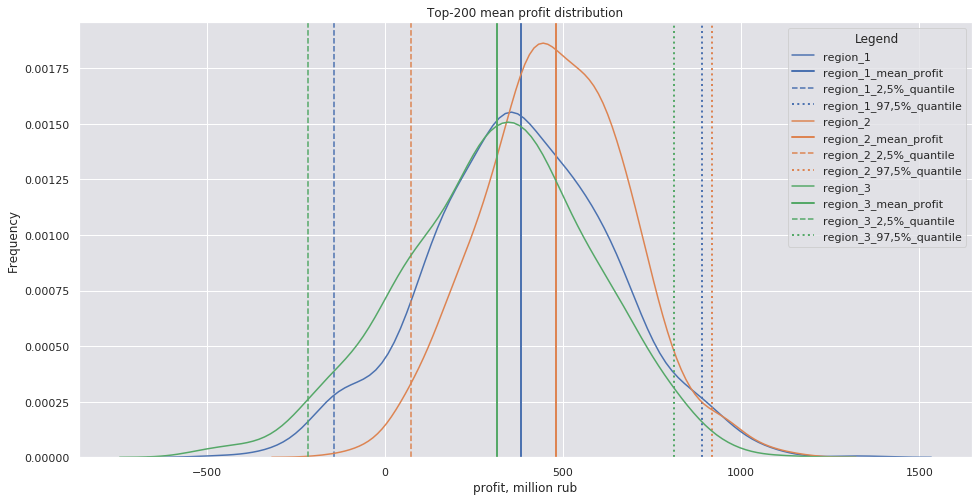

In [46]:
profit_total = []
lower_list = []
high_list = []
probability_loss_list = []

plt.figure(figsize=(16,8))
sns.set(rc={'axes.facecolor':'#e1e1e6'})
for region in range(len(xx)):
    df = df_predict_product[region]
    profit_list =[]
    for i in range(1000):
        subsample = df.sample(n=bore_explore, replace=True, random_state=state)
        subprofit = profit(subsample, best_bore)
        profit_list.append(subprofit)
    
    profit_list = pd.Series(profit_list)    
    profit_total.append(profit_list)
    
    lower = profit_list.quantile(0.025)
    lower_list.append(lower)
    high = profit_list.quantile(0.975)
    high_list .append(high)
    
    probability_loss = ((profit_list) <= 0).mean()
    probability_loss_list.append(probability_loss)
   
    sns.distplot(profit_list, label=result.index[region], hist=False)
    plt.axvline(x=profit_list.mean(), color=(sns.color_palette()[region]), label=postfix(result.index, '_mean_profit')[region], ls='-', lw=2)
    plt.axvline(x=lower, color=(sns.color_palette()[region]), label=postfix(result.index, '_2,5%_quantile')[region], ls='--')
    plt.axvline(x=high, color=(sns.color_palette()[region]), label=postfix(result.index, '_97,5%_quantile')[region], ls=':', lw=2)
plt.title('Top-200 mean profit distribution')
plt.legend(title="Legend")
plt.xlabel("profit, million rub")
plt.ylabel("Frequency")
plt.show()

Выведем датафрейм со средней прибылью топ-200 из 500 скважин по каждому региону. 

In [47]:
profit_df = pd.DataFrame(data = profit_total).T
profit_df.columns = ['region_1', 'region_2','region_3']
profit_df

,region_1,region_2,region_3
0,687.121,541.939,859.164
1,276.226,503.375,363.997
2,638.001,72.454,531.954
3,750.256,267.948,219.869
4,274.891,658.874,445.662
...,...,...,...
995,243.382,446.338,474.314
996,602.746,342.091,253.526
997,656.055,260.111,218.987
998,-2.713,668.889,540.356


Актуализируем датафрем с результатами по каждому региону.

In [48]:
probability_loss = pd.DataFrame(probability_loss_list, columns= ['probability_loss'], index=result.index)
lower = pd.DataFrame(lower_list, columns= ['0.025_qauntile'], index=result.index)
high = pd.DataFrame(high_list, columns= ['0.975_qauntile'], index=result.index)
mean = pd.DataFrame(profit_df.mean(), columns= ['mean_profit'], index=result.index)
result=result.join([lower, high, probability_loss, mean]).round(3)

Колонки в итоговом датафрейме:
- **rmse** - квадратный корень из среднеквадратичной ошибки (RMSE)
- **mean_predict** - среднее значение предсказаного объема сырья в регионе, тыс. барелей 
- **0.025_qauntile** - 2,5% квантиль средней прибыли топ-200 лучших по предсказаниям скважин из 500, млн. рублей
- **0.975_qauntile** - 97,5% квантиль средней прибыли топ-200 лучших по предсказаниям скважин из 500, млн. рублей
- **probability_loss** - вероятность убытков (стоимость разработки двухсот скважин больше прибыли от продажи сырья)
- **mean_profit** - среднее значение прибыли для каждого региона

In [49]:
result

,rmse,mean_predict,mean_payback,0.025_qauntile,0.975_qauntile,probability_loss,mean_profit
region_1,37.854,92.789,-18.311,-142.942,890.977,0.077,380.613
region_2,0.892,69.178,-41.922,73.849,917.954,0.006,479.160
region_3,40.076,94.866,-16.234,-216.265,811.061,0.124,315.442


### Вывод 

Результаты приведены в таблице выше.
- Второй регион единственный из трёх имеет вероятность убытков меньше 2,5%. Для первого региона вероятность убытков около 7%, для третьего около 12%. 
- Средняя прибыль больше всего так же у второго региона и составляет более 479 млн. руб. Первый и третий регион имеют среднюю прибыль около 380 и 315 млн. рублей соответственно.

## Общие выводы

Исследованы датасеты, для трех регионов предполагаемой добычи нефти. Выделены признаки f0, f1, f2, и целевой признак product. Признаки разных регионов имеют разное распределение.  

Наибольшее внимание вызывает второй датасет, в котором целевые признаки системно сгруппированы, а так же имеется очень сильная положительная корреляция между признаком f2 и целевым признаком product k=0.99994.  

Во всех датасетах обнаружены дублирующиеся id, которые были удалены. Всего это 4-10 объектов в каждом датасете или менее 0,01% данных.  

После разделения датасетов на обучающую и валидационную выборки в соотношении 75/25 и стандартизации признаков произведено обучение моделей линейной регрессии.
- Наименьший RMSE и среднее значение предсказанного целевого признака у второго региона, равные 0,89 и 69 соответственно. 
- Для первого и второго региона значения RMSE и среднего предсказания находятся в диапазоне 38-40 и 93-95 соответственно.  
Причина низкого среднеквадратичного отклонения второго региона можно объяснить наличием очень сильной линенйной корреляции признака f2 и целевого признака. 

Для безубыточной разработки новый скважины объём сырья должен быть не менее 111,1 тыс барелей. Средние значения предсказанного объёма сырья в каждом из регионов не превышают этого значения.  

Условие задачи предполагает исследование 500 скважин и выбор из них 200 лучших с помощью машинного обучения для дальнейшей разработки. В связи с этим техникой Boostrap проведен анализ возможной прибыли и рисков разработки меторождений каждого региона. Вероятность убытков должна составлять менее 2,5%.
- Второй регион единственный из трёх имеет вероятность убытков меньше 2,5%. Для первого региона вероятность убытков около 7%, для третьего около 12%.

- Средняя прибыль больше всего так же у второго региона и составляет 479,1 млн. руб. Первый и третий регион имеют среднюю прибыль 380 и 315 млн. рублей соответственно.  

Технически заданным условиями для разработки соотствует только второй регион. Он имеет уровень рисков менее 2,5% и самую высокую среднюю прибыль 200 лучших скважин из 500 исследованных. Однако в исходных данных (пункт 1.2) имеются существенные странности, способные повлиять на принятие решения. 
- У признака f2 гистограмма имеет вид столбчатой диаграммы со значениями 0, 1, 2, 3, 4, 5;
- Целевой признак так же имеет вид столбчатой диаграммы, но с парой пиков в каждом значении около 0, 30, 55, 80, 110, 135. При этом интервалы между парами ближайших значений и между пиками  одиннаковые с точностью до 8 знака после запятой. Можно предположить, что исходный датасет был заранее предобработан и сгруппирован.  
В связи с этим рекомендуется уточнить корректность исходных данных второго датасета и в случае корректности принять его для дальнейшей работы.

